**Load Libraries**

In [7]:
import numpy as np
import pandas as pd
from google.colab import drive
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json
TOLERANCE = 1e-10
import pickle
import statistics
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, dates as mdates
from scipy.stats import skew, kurtosis, norm
import statsmodels.api as sm
from scipy import stats
import seaborn as sns

In [8]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load Data, and compute volatility signals**

In [9]:
target = 0.18
fff = pd.read_csv('/content/drive/MyDrive/_Data_/ffm.csv', index_col = "dateff", parse_dates = True)[1:]
vix = pd.read_csv('/content/drive/MyDrive/_Data_/^VIX.csv', index_col = "Date", parse_dates = True)["Adj Close"]
rf = fff["rf"]
signals = []
for value in vix.values:
  if value > 30:
    signals.append("High")
  elif 15 < value <= 30:
    signals.append("Normal")
  else:
    signals.append("Low")

In [10]:
with open("/content/drive/MyDrive/_Data_/port_rets.json", "rb") as data:
    port_rets = pickle.load(data)[:-1] #the data only goes till march 2022, however the algorithm still calculates the return for april 2022, which is 0% given there is no data. So, we should ignore it

with open("/content/drive/MyDrive/_Data_/dates.json", "rb") as data:
    plot_dates = pickle.load(data)[12:] #We only have returns starting in the 13th month


**Full Sample**

In [11]:
excess_returns = pd.DataFrame(port_rets, index = plot_dates[1:], columns = ["Strategy Returns"]) 
excess_returns["Risk Free"] = rf.values
excess_returns["Excess Returns"] = excess_returns["Strategy Returns"] - excess_returns["Risk Free"]
rets = excess_returns["Excess Returns"].values

std = statistics.pstdev(rets) * np.sqrt(12) * 100
mean = np.mean(rets) * 12 * 100
skewness = skew(rets)
kurt = kurtosis(rets)
max = np.max(rets) * 100
min = np.min(rets) * 100
std_negative = statistics.pstdev([ret for ret in rets if ret < 0])  * np.sqrt(12) * 100

print("Standard Deviation: " + str(std) + "%")
print("Average Annual Return: " + str(mean) + "%")
print("Sharpe Ratio: " + str(mean/std))
print("Sortino Ratio: " + str(mean/std_negative))
print("Largest Gain: " + str(max) + "%")
print("Largest Loss: " + str(min) + "%") 
print("Skewness: " + str(skewness))
print("Kurtosis: " + str(kurt))

Standard Deviation: 7.618170663721882%
Average Annual Return: 7.827002954251165%
Sharpe Ratio: 1.0274123933090333
Sortino Ratio: 1.5676248808043896
Largest Gain: 9.314447486529419%
Largest Loss: -9.330472481742518%
Skewness: 0.139216288358358
Kurtosis: 2.8714981734348726


In [12]:
cum_ret = 1
cum_rets = [1]
for ret in rets:
  cum_ret = cum_ret * (1 + ret)
  cum_rets.append(cum_ret)

max_ret = 1
drawdowns = []
for ret in cum_rets:
  max_ret = np.max([max_ret, ret])
  drawdowns.append(-(max_ret - ret) / max_ret * 100)

df = pd.DataFrame(cum_rets, plot_dates, columns = ["Cumulative Return"])
df["Drawdown"] = drawdowns

print("Largest Drawdown: " + str(round(np.min(drawdowns), 2)) + "%")
print("Calmar Ratio: " + str(mean / -np.min(drawdowns)))

Largest Drawdown: -15.75%
Calmar Ratio: 0.4968831787099963


In [13]:
total = len(rets) - 1
positive = len([ret for ret in rets if ret > 0.0])
print("%Positive Days: " + str(positive/total * 100))

%Positive Days: 57.43944636678201


In [14]:
excess_returns["Volatility"] = signals[1:]
mean_low = np.mean(excess_returns[excess_returns["Volatility"] == "Low"]["Excess Returns"]) * 12
mean_medium = np.mean(excess_returns[excess_returns["Volatility"] == "Normal"]["Excess Returns"]) * 12
mean_high = np.mean(excess_returns[excess_returns["Volatility"] == "High"]["Excess Returns"]) * 12

std_low = excess_returns[excess_returns["Volatility"] == "Low"]["Excess Returns"].std() * np.sqrt(12)
std_medium = excess_returns[excess_returns["Volatility"] == "Normal"]["Excess Returns"].std() * np.sqrt(12)
std_high = excess_returns[excess_returns["Volatility"] == "High"]["Excess Returns"].std() * np.sqrt(12)

sharpe_low = mean_low / std_low
sharpe_medium = mean_medium / std_medium
sharpe_high = mean_high / std_high

print("Volatility     Return     Stdev    Sharpe Ratio")
print("    Low         " + str(round(mean_low, 3)) + "     " + str(round(std_low, 3)) + "       " + str(round(sharpe_low, 3)))
print("    Medium      " + str(round(mean_medium, 3)) + "     " + str(round(std_medium, 3)) + "       " + str(round(sharpe_medium, 3)))
print("    High        " + str(round(mean_high, 3)) + "     " + str(round(std_high, 3)) + "        " + str(round(sharpe_high, 3)))

Volatility     Return     Stdev    Sharpe Ratio
    Low         0.066     0.084       0.786
    Medium      0.086     0.077       1.127
    High        0.061     0.05        1.234


**First Half**

In [15]:
rets = excess_returns["Excess Returns"][:"2010"].values

std = statistics.pstdev(rets) * np.sqrt(12) * 100
mean = np.mean(rets) * 12 * 100
skewness = skew(rets)
kurt = kurtosis(rets)
max = np.max(rets) * 100
min = np.min(rets) * 100
std_negative = statistics.pstdev([ret for ret in rets if ret < 0])  * np.sqrt(12) * 100

print("Standard Deviation: " + str(std) + "%")
print("Average Annual Return: " + str(mean) + "%")
print("Sharpe Ratio: " + str(mean/std))
print("Sortino Ratio: " + str(mean/std_negative))
print("Largest Gain: " + str(max) + "%")
print("Largest Loss: " + str(min) + "%") 
print("Skewness: " + str(skewness))
print("Kurtosis: " + str(kurt))

Standard Deviation: 6.708704150425445%
Average Annual Return: 9.860843967872064%
Sharpe Ratio: 1.4698582239979565
Sortino Ratio: 2.3574057949623994
Largest Gain: 7.736819000191557%
Largest Loss: -6.3191135423987905%
Skewness: 0.21899261222017416
Kurtosis: 2.0599347954351837


In [16]:
cum_ret = 1
cum_rets = [1]
for ret in rets:
  cum_ret = cum_ret * (1 + ret)
  cum_rets.append(cum_ret)

max_ret = 1
drawdowns = []
for ret in cum_rets:
  max_ret = np.max([max_ret, ret])
  drawdowns.append(-(max_ret - ret) / max_ret * 100)

df = pd.DataFrame(cum_rets, plot_dates[:144], columns = ["Cumulative Return"])
df["Drawdown"] = drawdowns

print("Largest Drawdown: " + str(round(np.min(drawdowns), 2)) + "%")
print("Calmar Ratio: " + str(mean / -np.min(drawdowns)))

Largest Drawdown: -6.32%
Calmar Ratio: 1.5604789978388007


In [17]:
total = len(rets) - 1
positive = len([ret for ret in rets if ret > 0.0])
print("%Positive Days: " + str(positive/total * 100))

%Positive Days: 60.56338028169014


**Second Half**

In [18]:
rets = excess_returns["Excess Returns"]["2010":].values

std = statistics.pstdev(rets) * np.sqrt(12) * 100
mean = np.mean(rets) * 12 * 100
skewness = skew(rets)
kurt = kurtosis(rets)
max = np.max(rets) * 100
min = np.min(rets) * 100
std_negative = statistics.pstdev([ret for ret in rets if ret < 0])  * np.sqrt(12) * 100

print("Standard Deviation: " + str(std) + "%")
print("Average Annual Return: " + str(mean) + "%")
print("Sharpe Ratio: " + str(mean/std))
print("Sortino Ratio: " + str(mean/std_negative))
print("Largest Gain: " + str(max) + "%")
print("Largest Loss: " + str(min) + "%") 
print("Skewness: " + str(skewness))
print("Kurtosis: " + str(kurt))

Standard Deviation: 8.369602767597614%
Average Annual Return: 5.8485045532458%
Sharpe Ratio: 0.6987792271203018
Sortino Ratio: 1.07573364770662
Largest Gain: 9.314447486529419%
Largest Loss: -9.330472481742518%
Skewness: 0.17057384896596928
Kurtosis: 2.8882926182026356


In [19]:
cum_ret = 1
cum_rets = [1]
for ret in rets:
  cum_ret = cum_ret * (1 + ret)
  cum_rets.append(cum_ret)

max_ret = 1
drawdowns = []
for ret in cum_rets:
  max_ret = np.max([max_ret, ret])
  drawdowns.append(-(max_ret - ret) / max_ret * 100)

df = pd.DataFrame(cum_rets, plot_dates[143:], columns = ["Cumulative Return"])
df["Drawdown"] = drawdowns

print("Largest Drawdown: " + str(round(np.min(drawdowns), 2)) + "%")
print("Calmar Ratio: " + str(mean / -np.min(drawdowns)))

Largest Drawdown: -15.75%
Calmar Ratio: 0.37128177287045483


In [20]:
total = len(rets) - 1
positive = len([ret for ret in rets if ret > 0.0])
print("%Positive Days: " + str(positive/total * 100))

%Positive Days: 54.794520547945204


**Dot-com bubble (1998 - 2003)**

In [21]:
rets = excess_returns["Excess Returns"]["1998":"2004"].values

std = statistics.pstdev(rets) * np.sqrt(12) * 100
mean = np.mean(rets) * 12 * 100
skewness = skew(rets)
kurt = kurtosis(rets)
max = np.max(rets) * 100
min = np.min(rets) * 100
std_negative = statistics.pstdev([ret for ret in rets if ret < 0])  * np.sqrt(12) * 100

print("Standard Deviation: " + str(std) + "%")
print("Average Annual Return: " + str(mean) + "%")
print("Sharpe Ratio: " + str(mean/std))
print("Sortino Ratio: " + str(mean/std_negative))
print("Largest Gain: " + str(max) + "%")
print("Largest Loss: " + str(min) + "%") 
print("Skewness: " + str(skewness))
print("Kurtosis: " + str(kurt))

Standard Deviation: 7.683908958912854%
Average Annual Return: 11.312537358600862%
Sharpe Ratio: 1.4722372973301598
Sortino Ratio: 2.1427060571568552
Largest Gain: 7.736819000191557%
Largest Loss: -6.3191135423987905%
Skewness: -0.050186164255549996
Kurtosis: 1.7796056826907733


In [22]:
cum_ret = 1
cum_rets = [1]
for ret in rets:
  cum_ret = cum_ret * (1 + ret)
  cum_rets.append(cum_ret)

max_ret = 1
drawdowns = []
for ret in cum_rets:
  max_ret = np.max([max_ret, ret])
  drawdowns.append(-(max_ret - ret) / max_ret * 100)

df = pd.DataFrame(cum_rets, columns = ["Cumulative Return"])
df["Drawdown"] = drawdowns

print("Largest Drawdown: " + str(round(np.min(drawdowns), 2)) + "%")
print("Calmar Ratio: " + str(mean / -np.min(drawdowns)))

Largest Drawdown: -6.32%
Calmar Ratio: 1.790209541686209


In [23]:
total = len(rets) - 1
positive = len([ret for ret in rets if ret > 0.0])
print("%Positive Days: " + str(positive/total * 100))

%Positive Days: 64.28571428571429


**2007-2008 Market Crash (2007-2010)**

In [24]:
rets = excess_returns["Excess Returns"]["2007":"2011"].values

std = statistics.pstdev(rets) * np.sqrt(12) * 100
mean = np.mean(rets) * 12 * 100
skewness = skew(rets)
kurt = kurtosis(rets)
max = np.max(rets) * 100
min = np.min(rets) * 100
std_negative = statistics.pstdev([ret for ret in rets if ret < 0])  * np.sqrt(12) * 100

print("Standard Deviation: " + str(std) + "%")
print("Average Annual Return: " + str(mean) + "%")
print("Sharpe Ratio: " + str(mean/std))
print("Sortino Ratio: " + str(mean/std_negative))
print("Largest Gain: " + str(max) + "%")
print("Largest Loss: " + str(min) + "%") 
print("Skewness: " + str(skewness))
print("Kurtosis: " + str(kurt))

Standard Deviation: 4.448581726939674%
Average Annual Return: 3.5551191549995838%
Sharpe Ratio: 0.7991578829429009
Sortino Ratio: 1.5747865632021587
Largest Gain: 3.8569642255344796%
Largest Loss: -2.0295595242924103%
Skewness: 0.5796106979526683
Kurtosis: 0.23936157171894967


In [25]:
cum_ret = 1
cum_rets = [1]
for ret in rets:
  cum_ret = cum_ret * (1 + ret)
  cum_rets.append(cum_ret)

max_ret = 1
drawdowns = []
for ret in cum_rets:
  max_ret = np.max([max_ret, ret])
  drawdowns.append(-(max_ret - ret) / max_ret * 100)

df = pd.DataFrame(cum_rets, columns = ["Cumulative Return"])
df["Drawdown"] = drawdowns

print("Largest Drawdown: " + str(round(np.min(drawdowns), 2)) + "%")
print("Calmar Ratio: " + str(mean / -np.min(drawdowns)))

Largest Drawdown: -3.72%
Calmar Ratio: 0.956486338508785


In [26]:
total = len(rets) - 1
positive = len([ret for ret in rets if ret > 0.0])
print("%Positive Days: " + str(positive/total * 100))

%Positive Days: 42.5531914893617


**Covid**

In [27]:
rets = excess_returns["Excess Returns"]["2020":"2021"].values

std = statistics.pstdev(rets) * np.sqrt(12) * 100
mean = np.mean(rets) * 12 * 100
skewness = skew(rets)
kurt = kurtosis(rets)
max = np.max(rets) * 100
min = np.min(rets) * 100
std_negative = statistics.pstdev([ret for ret in rets if ret < 0])  * np.sqrt(12) * 100

print("Standard Deviation: " + str(std) + "%")
print("Average Annual Return: " + str(mean) + "%")
print("Sharpe Ratio: " + str(mean/std))
print("Sortino Ratio: " + str(mean/std_negative))
print("Largest Gain: " + str(max) + "%")
print("Largest Loss: " + str(min) + "%") 
print("Skewness: " + str(skewness))
print("Kurtosis: " + str(kurt))

Standard Deviation: 11.188724812184658%
Average Annual Return: -4.34978010491133%
Sharpe Ratio: -0.388764598104546
Sortino Ratio: -0.42553909145981983
Largest Gain: 4.382294062519982%
Largest Loss: -9.330472481742518%
Skewness: -1.3505746503837224
Kurtosis: 2.561964909561536


In [28]:
cum_ret = 1
cum_rets = [1]
for ret in rets:
  cum_ret = cum_ret * (1 + ret)
  cum_rets.append(cum_ret)

max_ret = 1
drawdowns = []
for ret in cum_rets:
  max_ret = np.max([max_ret, ret])
  drawdowns.append(-(max_ret - ret) / max_ret * 100)

df = pd.DataFrame(cum_rets, columns = ["Cumulative Return"])
df["Drawdown"] = drawdowns

print("Largest Drawdown: " + str(round(np.min(drawdowns), 2)) + "%")
print("Calmar Ratio: " + str(mean / -np.min(drawdowns)))

Largest Drawdown: -12.85%
Calmar Ratio: -0.33849687787019694


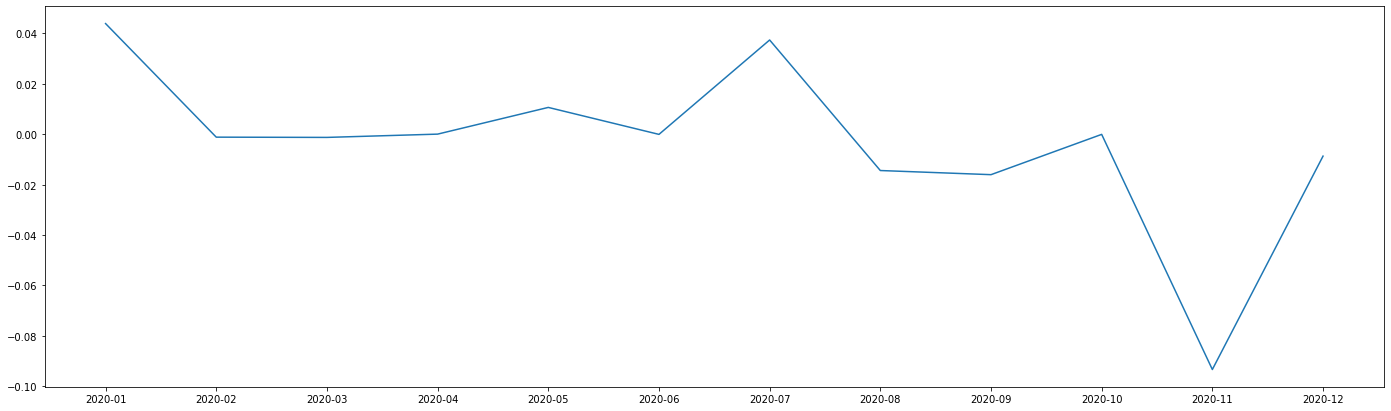

In [29]:
dates = excess_returns["Excess Returns"]["2020":"2021"].index
plt.figure(figsize=(24,7))
plt.plot(dates, rets)

**Factor Regression**

In [30]:
excess_returns = pd.DataFrame(port_rets, index = plot_dates[1:], columns = ["Strategy Returns"]) 
excess_returns["Strategy Returns"] = excess_returns["Strategy Returns"] 
excess_returns["Risk Free"] = rf.values
excess_returns["Excess Returns"] = excess_returns["Strategy Returns"] - excess_returns["Risk Free"]
rets = excess_returns["Excess Returns"].values

mom = pd.read_csv('/content/drive/MyDrive/_Data_/momentum.csv', index_col = "dateff", parse_dates = True)[1:]

fff = fff
fff["Momentum"] = mom["umd"].values
fff["Excess Returns"] = rets

port_excess = fff["Excess Returns"]
mkt_excess = fff["mktrf"]
exp_var = pd.DataFrame()
exp_var["Market - Rf"] = mkt_excess.copy()
exp_var["Constant"] = 1
exp_var["Value"] = fff["hml"]
exp_var["Size"] = fff["smb"]
exp_var["Momentum"] = fff["Momentum"]
lm = sm.OLS(port_excess, exp_var).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Excess Returns   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     17.77
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           4.86e-13
Time:                        21:53:10   Log-Likelihood:                 727.76
No. Observations:                 290   AIC:                            -1446.
Df Residuals:                     285   BIC:                            -1427.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Market - Rf     0.0053      0.028      0.187      0.852      -0.051       0.061
Constant        0.0060      0.001      5.019      0.000       0.004       0.008
Value           0.0162      0.036      0.445      0.657      -0.055       0.088
Size           -0.0596      0.038     -1.584      0.114      -0.134       0.014
Momentum        0.1904      0.025      7.624      0.000       0.141       0.240
==============================================================================
Omnibus:                       24.650   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.440
Skew:                           0.404   Prob(JB):                     5.55e-13
Kurtosis:                       5.005   Cond. No.                         34.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
replicating_port = excess_returns["Strategy Returns"].values - lm.params[0]*(fff['mktrf'].values + fff['rf'].values) -(1-lm.params[0])*fff['rf'].values -lm.params[2]*fff['hml'].values-lm.params[3]*fff['smb'].values-lm.params[4]*fff['Momentum'].values

In [32]:
te = replicating_port.std() 
alpha = np.mean(replicating_port) 
IR = alpha * 12 / (te * np.sqrt(12))

print("Information Ratio: " + str(IR))

Information Ratio: 1.0498639695925953


**Transaction Costs**

In [33]:
excess_returns = pd.DataFrame(port_rets, index = plot_dates[1:], columns = ["Strategy Returns"]) 
excess_returns["Strategy Returns"] = excess_returns["Strategy Returns"] - 0.003634 #through try and guess until t is close to 1.96
excess_returns["Risk Free"] = rf.values
excess_returns["Excess Returns"] = excess_returns["Strategy Returns"] - excess_returns["Risk Free"]
rets = excess_returns["Excess Returns"].values

mom = pd.read_csv('/content/drive/MyDrive/_Data_/momentum.csv', index_col = "dateff", parse_dates = True)[1:]

fff = fff
fff["Momentum"] = mom["umd"].values
fff["Excess Returns"] = rets

port_excess = fff["Excess Returns"]
mkt_excess = fff["mktrf"]
exp_var = pd.DataFrame()
exp_var["Market - Rf"] = mkt_excess.copy()
exp_var["Constant"] = 1
exp_var["Value"] = fff["hml"]
exp_var["Size"] = fff["smb"]
exp_var["Momentum"] = fff["Momentum"]
lm = sm.OLS(port_excess, exp_var).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Excess Returns   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     17.77
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           4.86e-13
Time:                        21:53:10   Log-Likelihood:                 727.76
No. Observations:                 290   AIC:                            -1446.
Df Residuals:                     285   BIC:                            -1427.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Market - Rf     0.0053      0.028      0.187      0.852      -0.051       0.061
Constant        0.0023      0.001      1.960      0.051   -9.53e-06       0.005
Value           0.0162      0.036      0.445      0.657      -0.055       0.088
Size           -0.0596      0.038     -1.584      0.114      -0.134       0.014
Momentum        0.1904      0.025      7.624      0.000       0.141       0.240
==============================================================================
Omnibus:                       24.650   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.440
Skew:                           0.404   Prob(JB):                     5.55e-13
Kurtosis:                       5.005   Cond. No.                         34.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Historical VaR**

In [34]:
rets = sorted(excess_returns["Excess Returns"].values)
length = len(rets)
index = round(length / 100, 0) - 1

var = rets[int(index)]

print("Historical VaR: " + str(var * 100) + "%")

Historical VaR: -6.175256127534389%


In [35]:
years = range(1998, 2023)
srs = []

for i in range(len(years)-1):
  rets = excess_returns['Excess Returns'][str(years[i]) : str(years[i+1])]
  mean = np.mean(rets)
  std = statistics.pstdev(rets)
  sr = mean/std * np.sqrt(12)
  srs.append(sr)

  print(str(years[i]) + ": " + str(sr))


rets = excess_returns['Excess Returns']["2022" : ]
mean = np.mean(rets)
std = statistics.pstdev(rets)
sr = mean/std * np.sqrt(12)
srs.append(sr)

print("2022: " + str(sr))

1998: 1.870756803992028
1999: 1.6791921171701063
2000: 0.8381731862719386
2001: 0.44594383971529833
2002: 0.8983490165053521
2003: -0.3396541368050236
2004: 0.6796476780595373
2005: 3.268629850956148
2006: 0.11202281868320017
2007: 1.2713349641377985
2008: -1.0969549448202127
2009: -1.7185593804686854
2010: -0.4208284953995594
2011: -0.2977857657746557
2012: -1.1686070176928445
2013: -0.9819805892834012
2014: 1.2029411518595845
2015: 0.6597792073883539
2016: -1.150198298367032
2017: 1.6145971760006008
2018: 1.3856787979960261
2019: -0.5508679400725144
2020: -0.7785141069360648
2021: 0.8849449101814019
2022: 3.649500147188924


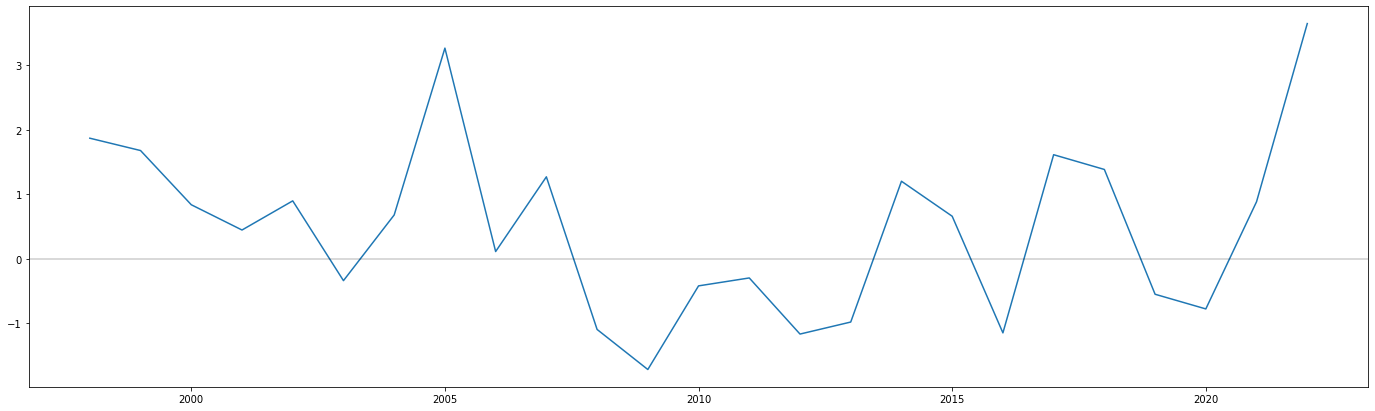

In [36]:
df = pd.DataFrame(srs, index = years)
plt.figure(figsize=(24,7))
plt.plot(df)
plt.axhline(y=0, color = "black", alpha = 0.2)